## Set up

In [1]:
from fastai.vision.all import *

set_seed(42)
trn_path = '/kaggle/input/ideitify'
files = get_image_files(trn_path)

## Bigger batch size

we will train with a bigger batch size this time. Using a large batch size during training has several potential advantages:

Efficiency: enables more efficient use of hardware resources by reducing the amount of time spent transferring data between the CPU and GPU.

Regularization: using larger batches can lead to smoother gradient estimates, reducing the noise in the gradients, and leading to a more stable optimization process.

Generalization: can help the model learn more generalizable patterns by exposing it to a larger variety of examples in each batch.

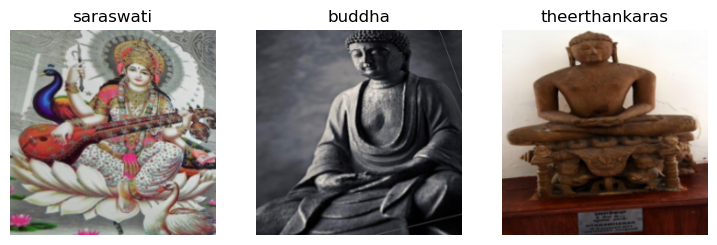

In [2]:
dls = ImageDataLoaders.from_folder(
    trn_path, 
    bs=256,
    seed=42,
    valid_pct=0.2,
    item_tfms=Resize(256, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

dls.show_batch(max_n=3)

In [3]:
arch = "vit_small_patch32_224"

top_3 = partial(top_k_accuracy, k=3)
top_5 = partial(top_k_accuracy, k=5)
metrics = [error_rate, accuracy, top_3, top_5]

## About label smoothing

The basic idea behind label smoothing is to encourage the model to be less confident in its predictions, and to avoid overfitting to the training data. This is achieved by replacing the hard training labels with soft labels that are distributed across all the classes, rather than being concentrated on a single class.

how does it work?
Say the one-hot-encoded vector of an image is [0, 1, 0, 0]. We replace all 0s with e/N, where N is the number of classes (here N=4) and e is a parameter (usually 0.1, which would mean we are 10% unsure of our labels). We also replaces the 1s with 1-e+e/N. The resulting one-hot-encoded vector would be [0.025, 0.925, 0.025, 0.025].

## Training for longer epochs with label smoothing 

In [5]:
learn = vision_learner(dls, arch, metrics=metrics,
                       loss_func=LabelSmoothingCrossEntropy(), path='.').to_fp16()

SuggestedLRs(valley=0.0030199517495930195, slide=0.004365158267319202)

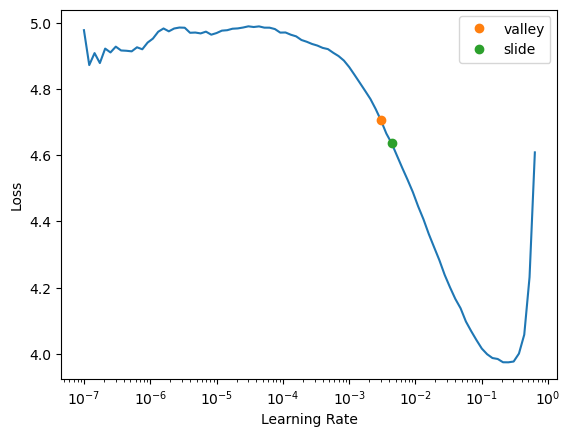

In [6]:
learn.lr_find(suggest_funcs=(valley, slide))

In [9]:
learn.fine_tune(12, 3e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.939599,2.252208,0.446349,0.553651,0.749841,0.844444,01:44


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.919315,1.631779,0.344127,0.655873,0.829206,0.903492,01:44
1,1.734717,1.557013,0.318095,0.681905,0.850794,0.914286,01:44
2,1.623025,1.538112,0.303492,0.696508,0.864127,0.920635,01:42
3,1.547288,1.567020,0.307937,0.692064,0.860952,0.911746,01:42
4,1.454370,1.511727,0.290159,0.709841,0.867936,0.921270,01:41
5,1.335373,1.405115,0.250159,0.749841,0.889524,0.939683,01:42
6,1.234092,1.395824,0.258413,0.741587,0.896508,0.939048,01:41
7,1.140954,1.321890,0.227937,0.772063,0.902222,0.942857,01:40
8,1.064074,1.296867,0.209524,0.790476,0.911111,0.948571,01:41
9,1.003653,1.276386,0.208889,0.791111,0.913651,0.948571,01:42


The metrics are way ahead of the baseline resnet18 model. We also see a reduce in training time because of a larger batch size.

## About mixup

<code>Mixup</code> is an image augmentation technique that involves taking two images from the dataset and creating a new image that is a linear combination of the two, where the pixel values are averaged according to the mixup ratio. The new label is also a linear combination of the two labels. This new image is then used as input to the model during training. The mixup technique is used to regularize the model and is useful when working with imbalanced datasets or when training with limited amounts of labeled data, as it can create additional synthetic training examples that can help improve the model's accuracy.

## Training for longer epochs with mixup.

In [14]:
# cbs = [EarlyStoppingCallback(monitor="accuracy", patience=4)]

mixup = MixUp(1.)
learn = vision_learner(dls, arch, metrics=metrics, cbs=mixup, path='.').to_fp16()
learn.fine_tune(12, 3e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,time
0,3.666538,2.408970,0.636825,0.363175,0.586032,0.713016,01:41


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,time
0,2.690467,1.567234,0.448254,0.551746,0.751746,0.837460,01:42
1,2.491559,1.396401,0.423492,0.576508,0.794286,0.867936,01:42
2,2.371014,1.307946,0.398730,0.601270,0.805714,0.880000,01:42
3,2.274971,1.228495,0.360635,0.639365,0.828571,0.895238,01:42
4,2.172869,1.215911,0.352381,0.647619,0.839365,0.894603,01:42
5,2.065086,1.029221,0.300952,0.699048,0.857778,0.923810,01:42
6,1.974971,0.971941,0.277460,0.722540,0.873016,0.923810,01:41
7,1.896026,0.927607,0.273651,0.726349,0.873016,0.923810,01:43
8,1.826393,0.912193,0.257778,0.742222,0.878730,0.933333,01:42
9,1.761393,0.868154,0.243810,0.756190,0.880635,0.937778,01:42


with mixup, we see improvements as we train for more epochs.

## Why early stopping is a bad idea

Early stopping may not yield the best model. This is because, in one-cycle training, the epochs in the middle occur before the learning rate has had a chance to reach the small values, where it can find the best result. The right way is to retrain the model from scratch again, this time with number of epochs based on where our previous best esults were found.

## Test time augmentation

To make the predictions even better, we can try test time augmentation (TTA).

During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.

In [15]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [16]:
print(error_rate(preds, targs))
print(accuracy(preds, targs))

TensorBase(0.2463)
TensorBase(0.7537)


In [17]:
tta_preds,_ = learn.tta(dl=valid)

In [19]:
print(error_rate(tta_preds, targs))
print(accuracy(tta_preds, targs))

TensorBase(0.2184)
TensorBase(0.7816)


TTA does boost the accuracy of our model.